In [1]:
import pandas as pd
from math import sqrt

from ProjectTools import OpenBeds

In [3]:
dry = True

def filter_on_depth(df):
    average = df["readCount"].mean()
    df = df[df["readCount"].ge(10)]
    df = df[df["readCount"].le(average + 3*sqrt(average))]
    return df

if dry == True:
    wgbs_bed_path = './test_data/ENCSR893RHD_modifications_mm39_sub.bed'
    nano_5mc_bed_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    nano_5hmC_bed_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_5hmC_sub.bed'
    
    wgbs_df = filter_on_depth(OpenBeds.get_wgbs(wgbs_bed_path))
    nano_mc_df = filter_on_depth(OpenBeds.get_nanopore_5mc(nano_5mc_bed_path))

    tab_df = filter_on_depth(OpenBeds.get_tab(tab_bed_path))
    nano_hmc_df = filter_on_depth(OpenBeds.get_nanopore_5hmc(nano_5hmC_bed_path))

else:
    wgbs_bed_path = './data/ENCSR893RHD_modifications_mm39.bed'
    nano_5mc_bed_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    tab_bed_path = './data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    nano_5hmC_bed_path = './data/prom_R10.4.1_E8.2_WGS_brain_5hmC.bed'

    wgbs_df = filter_on_depth(OpenBeds.get_wgbs(wgbs_bed_path))
    nano_mc_df = filter_on_depth(OpenBeds.get_nanopore_5mc(nano_5mc_bed_path))
    tab_df = filter_on_depth(OpenBeds.get_tab(tab_bed_path))
    nano_hmc_df = filter_on_depth(OpenBeds.get_nanopore_5hmc(nano_5hmC_bed_path))



In [19]:
from pybedtools import BedTool

ref_features = BedTool('./feature_references/mm39_all_features.bed')

mc_bed = BedTool.from_dataframe(pd.concat([nano_mc_df, wgbs_df]))
hmc_bed = BedTool.from_dataframe(pd.concat([tab_df, nano_hmc_df]))
ref_features = BedTool('./feature_references/mm39_all_features.bed')

def define_intergenic(mod_bed):
    df_of_non_intersects = BedTool.intersect(mod_bed, ref_features, v=True).to_dataframe(
        names=["chromosome", "chromStart", "chromEnd", "modification_type", "readCount", "percentMeth", "method", "feature"])
    df_of_non_intersects["feature"] = "Intergenic"
    return df_of_non_intersects

def find_all_intersects(mod_bed):
    features_df = BedTool.intersect(mod_bed, ref_features, wb=True).to_dataframe(
        names=["chromosome", "chromStart", "chromEnd", "modification_type", "readCount", "percentMeth", "method", "dup1", "dup2", "dup3", "feature"])
    features_df.loc[features_df["feature"].str.contains("CpG"), "feature"] = "CGI"
    intergenic_df = define_intergenic(mod_bed)


    return pd.concat([features_df, intergenic_df]).drop(columns=["dup1", "dup2", "dup3"])

In [20]:
mc_intersects_df = find_all_intersects(mc_bed)
hmc_intersects_df = find_all_intersects(hmc_bed)
hmc_intersects_df.loc[hmc_intersects_df["method"] == "Nanopore 5hmC", "method"] = "Nanopore"
mc_intersects_df.loc[mc_intersects_df["method"] == "Nanopore 5mC", "method"] = "Nanopore"


<Axes: xlabel='percentMeth', ylabel='feature'>

/u/n/doh28/.conda/envs/NanoporeEvaluationVenv/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/u/n/doh28/.conda/envs/NanoporeEvaluationVenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


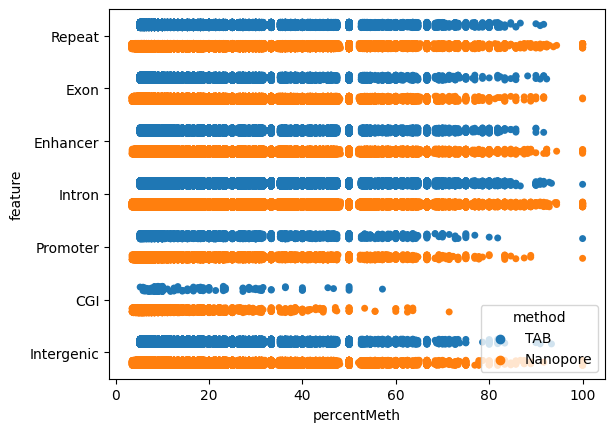